In [1]:
# 数据处理
import pandas as pd
import numpy as np
import json
import csv
import random
import math
from itertools import product


# 网络分析与可视化
import networkx as nx
from pyvis import network as net
import matplotlib.pyplot as plt
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α

## Functions

In [2]:

## 抽取关联网络
def Extract_Association_Network(df, entity_col, association_col, strength_thres):
    Source = []
    Target = []
    Strength = []
    
    entities = list(df[entity_col].unique())
    
    for i in range(len(entities)):
        for j in range(1, (len(entities) - i)):
            listA = list(df[df[entity_col]==entities[i]][association_col].unique())
            listB = list(df[df[entity_col]==entities[i+j]][association_col].unique())
            strength = len(set(listA)&set(listB))
            if strength > strength_thres:
                #print(features[i],features[i+j],features)
                Source.append(entities[i])
                Target.append(entities[i+j])
                Strength.append(strength)
                
    data_AssociationNetwork = {'Source': Source, 'Target': Target, 'Strength': Strength}
    df_AssociationNetwork = pd.DataFrame(data = data_AssociationNetwork)
    return df_AssociationNetwork



## 查找概念间共有的语义特征
def Extract_Associate_SemanticFeature(df, entity_col, association_col, concept_A, concept_B):
    listA = list(df[df[entity_col]==concept_A][association_col].unique())
    listB = list(df[df[entity_col]==concept_B][association_col].unique())
    return set(listA)&set(listB)



# 搜索出概念对应的所有语义特征及其激活状态，并按照 线索度cue_validity 排序 
def List_Semantic_Feature(df, concept):
    return df[df['Concept']==concept].sort_values(by=['cue_validity', 'activation'],ascending=False)[['Feature','cue_validity','activation']]



## 随机采样，模拟受损的个人语义网络
def Sample_PWA(df, sample_rate, mark_col):
    np.random.seed(10)
    remove_n = round(len(df)*sample_rate)
    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    
    df_sample = df.copy()
    df_sample[mark_col] = 0
    for row in df_sample.iterrows():
        if row[0] in drop_indices:
            df_sample.loc[row[0],mark_col] = 1
        else:
            pass

    # return df_sample[df_sample[mark_col]==1]
    return df_sample




## 将 CSV 转成 Json 文件
# 为了适应NodeTrix/G6等不同库的数据格式需求，设置两个参数
# link_object_name: "links" / "edges" 
# node_content_mode: "index" / "name"



def Node_Link_CSV2Json(df_link, df_node, node_name_col, node_group_col, link_object_name, node_content_mode):  
    data = {
        "nodes": [],
        link_object_name: []
    }
    groups = []

    nodes = list(set(list(df_link.Source)+list(df_link.Target)))
    for node in nodes: 
        df_selected_node = df_node[df_node[node_name_col]==node]
        group = list(df_selected_node[node_group_col])[0]
        if group not in groups:
            groups.append(group)
        new_node = {        
            "id":list(df_selected_node[node_name_col])[0],
            "group":groups.index(group)
        } 
        if new_node not in data['nodes']:
            data['nodes'].append(new_node)

    for row in df_link.iterrows():
        if node_content_mode == "index":
            new_link = {
                "source":nodes.index(row[1]['Source']),
                "target":nodes.index(row[1]['Target']),
                "value":int(row[1]['Strength'])
            }
        elif node_content_mode == "name":
            new_link = {
                "source":row[1]['Source'],
                "target":row[1]['Target'],
                "value":int(row[1]['Strength'])
            }
            
        if new_link not in data[link_object_name]:
            data[link_object_name].append(new_link)
            
    print("nodes: "+str(len(data['nodes'])))
    print("links: "+str(len(data[link_object_name])))
            
    return data



# 两个值域区间映射
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)


# def searchCategory(df, superiorCategory, subCategory, keyword):
#     df_category = df[df['上级类别']==superiorCategory]

#     if superiorCategory == '':
#         return '上级类别有：'+str(df['上级类别'].unique().tolist())
#     else:
#         if subCategory == '':
#             df_category = df[df['上级类别']==superiorCategory]
#             return str(superiorCategory) + '中的下级类别有：' + str(df_category['下级类别'].unique().tolist())
#         else:
#             if keyword == '':
#                 df_category = df[df['上级类别']==superiorCategory]
#                 df_subcategory = df_category[df_category['下级类别']==subCategory]
#                 print(str(superiorCategory)+'-'+str(subCategory) + '中的概念数量为：'+str(len(df_subcategory)))
#                 return df_subcategory
#             else:
#                 df_category = df[df['上级类别']==superiorCategory]
#                 df_subcategory = df_category[df_category['下级类别']==subCategory]
#                 for row in df_subcategory.iterrows():
#                     features = df_features[df_features['概念']==row[1]['概念']].特征.tolist()
#                     feature_str = ','.join(features)
#                     if keyword in feature_str:
#                         print(row[1]['概念'])



def get_children(df, row_name):
    classes = set()
    for i, row in df.iterrows():
        classes.add(row[row_name])
    return classes


# 查看节点Degree分布
def NodeDegreeHist(G):
    # degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    # dmax = max(degree_sequence)
    # plt.hist(degree_sequence)
    # plt.show()
    degree = nx.degree_histogram(G)  # 返回图中所有节点的度分布序列
    x = range(len(degree))  # 生成X轴序列，从1到最大度
    y = [z / float(sum(degree)) for z in degree]  # 将频次转化为频率
    plt.scatter(x, y, s=1, color=(1, 0, 0))  # 绘制度分布
    plt.show()  # 显示图表


# 查看连接Weight分布
def EdgeWeightHist(G):
    weight_sequence = sorted([e['weight'] for u,v,e in G.edges(data=True)], reverse=True)
    dmax = max(weight_sequence)
    plt.hist(weight_sequence)
    plt.show()


# 查看全部节点在某个属性的所有选项
def NodeAttributeValueList(G,attribute):
    return set(np.array([G.nodes[n][attribute] for n in G.nodes]).flatten())


# 搜索满足某个属性值的所有节点
def NodeMatchByAttribute(G,attribute,value):
    nodes = []
    for n in G.nodes:
        if G.nodes[n][attribute]==value:
            nodes.append(n)
    return nodes


# 类别子图
def ClusterFilter(G,nodeAttribute, nodeValue, edgeAttribute, edgeValue, writeFile, format):

    # 筛选子图 Node & Edge Attribute Filter
    def filter_node(node):
        if G.nodes[node][nodeAttribute] == nodeValue:
            return node 

    def filter_edge(u,v):
        if G[u][v][edgeAttribute] > edgeValue:
            return G[u][v]

    view = nx.subgraph_view(G,filter_node=filter_node, filter_edge=filter_edge,)
    largest_cc = max(nx.connected_components(view), key=len)
    view = view.subgraph(largest_cc)

    # 储存文件
    if writeFile == True:
        if format == 'Gephi':
            fileName = '02_Graph/ConceptNetwork_'+nodeAttribute+'_'+str(nodeValue)+'_'+edgeAttribute+str(edgeValue)+'.gexf'
            nx.write_gexf(view, fileName)

        else:
            fileName = '02_Graph/ConceptNetwork_'+nodeAttribute+'_'+str(nodeValue)+'_'+edgeAttribute+str(edgeValue)+'.json'
            # fileName = '02_Graph/Wenyue/ConceptNetwork_'+nodeAttribute+'_'+str(nodeValue)+'.json'
            with open(fileName,'w+') as f:
                if format == 'G6':
                    f.write(json.dumps(nx.node_link_data(view), ensure_ascii=False).replace('links','edges'))
                if format == 'D3':
                    f.write(json.dumps(nx.node_link_data(view), ensure_ascii=False))

    # 打印提示
    print("Number of Nodes:",len(view.nodes))
    print("Node Degree Hist")
    NodeDegreeHist(view)
    print("Edge Weight Hist")
    EdgeWeightHist(view)
    
    return view



# 将子图内的节点按重要性排序，以logspace采样出指定数量的节点
def NodeSampling(G,num_of_sample, mode):
    pr = nx.pagerank(G, alpha=0.85,weight='weight')
    words = list(dict(sorted(pr.items(), key=lambda item: item[1], reverse=True)))

    if mode == 'log':
        # np.logspace(start, end, num_of_samples, endpoint=True, base=10.0)
        index_list = np.logspace(0, math.log(len(words),10), num_of_sample, endpoint=True)
        index_list = set([int(x) for x in index_list])
        words = [words[i] for i in index_list]
    elif mode == 'top':
        words = words[0:num_of_sample]

    return words

## 语义特征数据分析

In [3]:
## 导入完整的概念-特征网络

# 导入concept-feature 连接数据
# df_rel_raw = pd.read_csv('00_Raw Data/All concepts and features.csv')

# # 导入concept 节点属性数据
# df_concept_info = pd.read_csv('00_Raw Data/CCFD_concept_info.csv')

# # join 成一张表
# df_complete = df_rel_raw.join(df_concept_info.set_index('Id'), on='Concept').drop(["Unnamed: 4", "Label", "concept", "superior category", "subcategory"], axis=1)


# # 计算特征线索度：特征对某个概念的线索度 = 特征在概念下出现的频率 / 特征在所有概念下出现的频率总和
# cue_validities = []

# for row in df_complete.iterrows():
#     cue_validity = row[1]['Frequency'] / sum(list(df_complete[df_complete['Feature']==row[1]['Feature']]['Frequency']))
#     cue_validities.append(cue_validity)

# df_complete['cue_validity'] = cue_validities
# df_complete.head()


# # 计算范畴独有度
# categorical_distinctiveness = []

# for row in df_complete.iterrows():
#     distinctiveness_value = len(df_complete[(df_complete['上级类别']==row[1]['上级类别']) & (df_complete['Feature'] == row[1]['Feature'])]) / len(df_complete[df_complete['上级类别']==row[1]['上级类别']].Concept.unique()) 
#     categorical_distinctiveness.append(distinctiveness_value)

# df_complete['categorical_distinctiveness'] = categorical_distinctiveness
# df_complete.head()

# # 保存文件
# df_complete.to_csv('01_Processed Data/Complete-Data.csv',index=False)


,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity,categorical_distinctiveness
0,安全带,可以,可以-保护,27.096774,9.0,9.0,人造物,工具,0.851345,0.038320,0.158537
1,安全带,是,是-带子,22.258065,9.0,9.0,人造物,工具,0.851345,0.286019,0.012195
2,安全带,其他,其他-车,17.419355,9.0,9.0,人造物,工具,0.851345,0.122012,0.021341
3,安全带,是,是-安保的,16.451613,9.0,9.0,人造物,工具,0.851345,0.089938,0.041159
4,安全带,可以,可以-保护人,15.483871,9.0,9.0,人造物,工具,0.851345,0.149063,0.035061


In [4]:
# 读取已经处理好的完整语义网络数据

df_complete = pd.read_csv('01_Processed Data/Complete-Data.csv')
df_complete.head()

,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity,categorical_distinctiveness
0,安全带,可以,可以-保护,27.096774,9.0,9.0,人造物,工具,0.851345,0.038320,0.158537
1,安全带,是,是-带子,22.258065,9.0,9.0,人造物,工具,0.851345,0.286019,0.012195
2,安全带,其他,其他-车,17.419355,9.0,9.0,人造物,工具,0.851345,0.122012,0.021341
3,安全带,是,是-安保的,16.451613,9.0,9.0,人造物,工具,0.851345,0.089938,0.041159
4,安全带,可以,可以-保护人,15.483871,9.0,9.0,人造物,工具,0.851345,0.149063,0.035061


In [5]:
# 列出共有某个语义特征的同类概念

def List_Related_Concepts(concept,feature):
    main_category = df_complete[df_complete['Concept'] == concept]['上级类别'].unique()[0]
    related_concepts = list(df_complete[(df_complete['上级类别'] == main_category) & (df_complete['Feature'] == feature)]['Concept'].unique())
    related_concepts = list(filter(lambda x: x != concept, related_concepts))

    return related_concepts

# List_Related_Concepts('安全带','可以-保护人')


# 易混淆的语义特征
# 给到（概念，语义特征）
#   选出所有的同类概念，选出所有同类语义特征，计算每个同类语义特征在该类概念中的线索度
#     按照线索度高低排序
#         如果该特征不为该概念所有
#             则作为混淆项

def List_Confused_Feature(concept, feature):
    related_concepts = List_Related_Concepts(concept,feature)
    df_related = df_complete[(df_complete['Concept'].isin(related_concepts))]

    relationship = df_complete[(df_complete['Concept'] == concept) & (df_complete['Feature'] == feature)]['Rel'].unique()[0]
    confused_feature_list = list(df_related[df_related['Rel'] == relationship].sort_values(by=['categorical_distinctiveness','cue_validity'],ascending=False)['Feature'].unique())
    confused_feature_list = list(filter(lambda x: x not in list(df_complete[df_complete['Concept'] == concept]['Feature']), confused_feature_list))

    return (confused_feature_list)

# List_Confused_Feature('安全带','可以-保护人')[0:10]



# 列出该概念独有的语义特征
def ListUniqueFeatures(concept):
    unique_features = {}
    df_ = df_complete[df_complete['Concept']==concept]
    feature_list = list(df_['Feature'])
    for feature in feature_list:
        concept_list = list(df_complete[df_complete['Feature']==feature]['Concept'].unique())
        if len(concept_list) < 3:
            (frequency, cue_validity) = df_[df_['Feature']==feature][['Frequency', 'cue_validity']].values[0]
            unique_features[feature] = [frequency, cue_validity]
    unique_features = dict(sorted(unique_features.items(), key = lambda item: item[1],reverse=True))
    return unique_features
            # print(feature,"frequency: "+str(frequency), "cue_validity: "+str(cue_validity))

# ListUniqueFeatures('葡萄酒')


## 概念网络分析

In [633]:
# 从完整数据中抽取概念层级树

root = {
    "id": "root",
    "children": []
}

for i in get_children(df_concept_info, '上级类别'):
    data_subclass = df_concept_info[df_concept_info['上级类别']==i]
    class_dic = {
        "id": i,
        "value":len(data_subclass),
        "children": []
    }
    root['children'].append(class_dic)
    
    for j in get_children(data_subclass,'下级类别'):
        if j not in get_children(df_concept_info, '上级类别'):
            data_word = data_subclass[data_subclass['下级类别']==j]
            subclass_dic = {
                "id": j,
                "value": len(data_word),
                # "children": []
            }
            class_dic['children'].append(subclass_dic)
        
        # for k in get_children(data_word,'word'):
        #     word_dic = {
        #         "name" : k,
        #         "value" : 0
        #     }
        #     subclass_dic['children'].append(word_dic)     


# # 保存
# with open("00_Raw Data/Concepts_Tree.json", "w") as f: 
#     json.dump(root, f, ensure_ascii=False)

In [ ]:

# # 搜索与目标概念有语义关联的概念
def SimilarConcepts(G, concept, n):
    edges={}
    for u,v,e in G.edges(concept, data=True): # 列出与节点相连的所有边
        if v!= concept:
            edges[v]=e['weight']
    edges = dict(sorted(edges.items(), key=lambda item: item[1],reverse=True))
    return list(edges.items())[:n]#给边按权重排序，列出前n个的相连节点

SimilarConcepts(G_ConceptNetwork,'轿车',5)


# # 搜索与目标概念共有某个语义特征的相关概念
def SimilarConceptsBySharedFeature(G, concept, feature):
    edges={}
    words = []
    for u,v,e in G.edges(concept, data=True): # 列出与节点相连的所有边
        if v!= concept:
            edges[v]=e['weight']
    edges = dict(sorted(edges.items(), key=lambda item: item[1],reverse=True))
    for i in edges.items():
        shared_feature = Extract_Associate_SemanticFeature(df_complete, 'Concept', 'Feature', concept, i[0])
        if feature in shared_feature:
            words.append(i[0])
    return words

SimilarConceptsBySharedFeature(G_ConceptNetwork, '轿车', '有-油门')


In [8]:
## 方法一 ----------------------------------------
## 从完整网络中抽取概念关联网络 / 特征关联网络 （会运行很久）

# 抽取概念关联网络
# df_ConceptNetwork = Extract_Association_Network(df_complete, 'Concept', 'Feature', 0)
# df_ConceptNetwork.to_csv('02_Graph/Concept_Link.csv',index=False)

# 抽取特征关联网络
# df_FeatureNetwork = Extract_Association_Network(df_complete, 'Feature', 'Concept', 0)
# df_FeatureNetwork.to_csv('02_Grapha/SemanticFeature_Link.csv',index=False)

# 读取概念关联网络
# df_ConceptNetwork = pd.read_csv('02_Graph/Concept_Link.csv')

# # 将概念关联网络导入NetworkX
# G_ConceptNetwork = nx.Graph()
# for row in df_ConceptNetwork.iterrows():
#     G_ConceptNetwork.add_edge(row[1]['Source'], row[1]['Target'], weight=int(row[1]['Strength']))



## 方法二 ----------------------------------------
# 将CCFD研究中计算好的 Concept Matrix 导入NetworkX
input_data = pd.read_csv('00_Raw Data/CCFD_Concept-similarity-matrix.csv', index_col=0)
G = nx.Graph(input_data.values)

def filter_edge(u,v):
    if G[u][v]['weight'] > 0.26:
    # if G[u][v]['weight'] > 0:

        return G[u][v]

G_ConceptNetwork = nx.subgraph_view(G,filter_edge=filter_edge,)

# 给节点加上label
def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l

with open('00_Raw Data/CCFD_Concept-similarity-matrix.csv', 'r', encoding='utf-8-sig') as f:
    d_reader = csv.DictReader(f)
    headers = d_reader.fieldnames

labels=make_label_dict(headers)

G_ConceptNetwork = nx.relabel_nodes(G_ConceptNetwork, labels)


# 加入分类标签
for node in G_ConceptNetwork.nodes:
    G_ConceptNetwork.nodes[node]['subcategory']=list(df_complete[df_complete['Concept']==node]['下级类别'].unique())[0]
    G_ConceptNetwork.nodes[node]['maincategory']=list(df_complete[df_complete['Concept']==node]['上级类别'].unique())[0]

# # 打印提示
# print("Number of Nodes:",len(G_ConceptNetwork.nodes))
# print("Number of Edges:",len(G_ConceptNetwork.edges))

# print("Node Degree Hist")
# NodeDegreeHist(G_ConceptNetwork)
# print("Edge Weight Hist")
# EdgeWeightHist(G_ConceptNetwork)



# # 将全图导出 for G6
# with open('02_Graph/ConceptNetwork_Complete_CCFD-Similarity-Matrix_Weight-0.52.json','w+') as f:
#     f.write(json.dumps(nx.node_link_data(G_ConceptNetwork), ensure_ascii=False).replace('links','edges'))

# # 将全图导出 for Gephi
# nx.write_gexf(G_ConceptNetwork, "02_Graph/ConceptNetwork_Complete_CCFD-Similarity-Matrix_Weight-0.52.gexf")


In [38]:
# # Power law test

# degree_sequence = sorted([d for n, d in G_ConceptNetwork.degree()], reverse=True) # used for degree distribution and powerlaw test
# fit = powerlaw.Fit(degree_sequence) 
# fit.power_law.alpha
# fit.power_law.sigma
# fit.distribution_compare('power_law', 'exponential')
# # fig2 = fit.plot_pdf(color='b', linewidth=2)
# # fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)


Calculating best minimal value for power law fit


(-1.9434413248986835, 0.024600488499433405)

In [51]:
# # 测试Edge Filter的参数用。用完整的，未经过边筛选的 G_ConceptNetwork
# for u,v,e in G_ConceptNetwork.edges(data=True):
#     if ((e['weight'] < 0.66) & (e['weight']>0.65)):
#         shared_features = Extract_Associate_SemanticFeature(df_complete, 'Concept', 'Feature', u, v)
#         if shared_features !=0:
#             print(e['weight'],u,v,shared_features)

0.650351386 安全帽 栏杆 {'是-金属', '是-安保的', '有-多种颜色', '可以-保护', '需要-清洗', '是-工具', '可以-保护人', '需要-制造', '是-硬的'}
0.658552342 鹌鹑 啄木鸟 {'需要-睡觉', '是-小的', '需要-虫', '有-羽毛', '有-爪子', '可以-飞', '有-翅膀', '有-眼睛', '需要-食物', '可以-捕猎', '有-嘴巴', '需要-水', '需要-空气', '是-动物', '是-鸟'}
0.653403849 巴士 房车 {'是-车', '有-方向盘', '是-大的', '需要-汽油', '其他-交通', '需要-加油', '可以-行驶', '可以-乘坐', '需要-电', '有-窗户', '像-公交车', '有-车厢', '需要-修理', '需要-清洗', '是-工具', '需要-油', '需要-维护', '需要-驾驶', '可以-移动', '有-轮子', '需要-保养', '有-座位', '需要-司机'}
0.652829984 巴士 卡丁车 {'需要-驾驶', '是-车', '有-轮子', '有-方向盘', '有-车厢', '需要-保养', '可以-行驶', '需要-汽油', '其他-交通', '需要-司机', '是-工具', '有-窗户', '有-座位', '需要-油', '有-刹车', '需要-维护'}
0.652855786 芭蕾舞裙 比基尼泳装 {'需要-买', '有-上衣', '可以-穿', '有-多种样式', '是-服饰', '有-布', '有-多种颜色', '需要-设计', '是-好看的', '需要-清洗', '需要-制造', '是-衣服'}
0.65417811 芭蕾舞裙 斗篷 {'可以-穿', '有-多种样式', '是-服饰', '需要-缝纫', '有-布', '有-多种颜色', '需要-设计', '需要-清洗', '像-伞', '需要-制造', '是-衣服'}
0.651569472 芭蕾舞裙 长袍 {'像-裙子', '可以-穿', '有-多种样式', '是-服饰', '需要-缝纫', '有-布', '有-多种颜色', '需要-设计', '是-好看的', '需要-清洗', '需要-制造', '是-衣服'}
0.655686558 芭蕾舞裙 中山装

In [70]:
nx.multi_source_dijkstra(G_ConceptNetwork, {'轿车', '拇指'},'老虎', weight='weight')

(1.13760005, ['拇指', '眉毛', '石膏', '啄木鸟', '老虎'])

In [72]:
for path in sorted(nx.all_simple_edge_paths(G_ConceptNetwork, '拇指', '老虎', cutoff=5)):
    print(path)

In [13]:
# 从整图中提取包含制定节点的子图

node_list = ['画笔','蜡笔','手掌','手','臀部','手臂','手指','钢笔','画纸','记号笔']

def filter_node(node):
    if node in node_list:
        return node 

view = nx.subgraph_view(G_ConceptNetwork,filter_node=filter_node,)

# with open('05_PlanGraph/PlanGraph_Sample.json','w+') as f:
#     f.write(json.dumps(nx.node_link_data(view), ensure_ascii=False).replace('links','edges'))

## Graph Summary

In [1110]:
# 抽取Maincategory子图间的关联网络 Graph Summary for Maincategorys

G_Summary = nx.Graph()
G_Summary.add_nodes_from(maincategorys)
G_Summary.add_edges_from((a,b) for a,b in product(maincategorys,maincategorys) if a!=b)

# add node count into each node
for n,v in G_Summary.nodes(data=True):
    v['count'] = len(df_concept_info[df_concept_info['上级类别']==n])
    v['maincategory'] = n


# add edge weight into each edge
for u,v,e in G_Summary.edges(data=True):
    e['weight'] = 0

for u,v,e in G_ConceptNetwork.edges(data=True):
    u_maincategory = G_ConceptNetwork.nodes[u]['maincategory']
    v_maincategory = G_ConceptNetwork.nodes[v]['maincategory']
    if  u_maincategory!=v_maincategory:
        G_Summary[u_maincategory][v_maincategory]['weight']+=e['weight']

# # 导出 for G6
# with open('02_Graph/ConceptNetwork_Summary_CCFD-Similarity-Matrix_Weight-0.52.json','w+') as f:
#     f.write(json.dumps(nx.node_link_data(G_Summary), ensure_ascii=False).replace('links','edges'))

# with open('02_Graph/Wenyue/ConceptNetwork_Summary.json','w+') as f:
#     f.write(json.dumps(nx.node_link_data(G_Summary), ensure_ascii=False))

# 导出 for Gephi
nx.write_gexf(G_Summary, "02_Graph/ConceptNetwork_Summary_CCFD-Similarity-Matrix_Weight-0.52.gexf")

In [1108]:
# Gephi to Cytoscape
def Gephi2Cytoscape(filename):
    G=nx.read_graphml(filename)
    nx.node_link_data(G)

    red = nx.get_node_attributes(G, 'r')
    green = nx.get_node_attributes(G, 'g')
    blue = nx.get_node_attributes(G, 'b')
    rgb={node:'#%02x%02x%02x' % (red[node], green[node], blue[node]) for node in red}
    nx.set_node_attributes(G, rgb, 'rgb')

    for node in G:
        for attr in G.nodes[node]:
            if G.nodes[node][attr] is None:
                G.nodes[node][attr]=''

    filename_split = filename.split('.')
    if len(filename_split)>2:
        name = '.'.join(filename_split[0:(len(filename_split)-1)])
        extension = filename_split[len(filename_split)-1]
    else:
        (name,extension)=filename.split('.')
    print(name,extension)
    newfile=name+'-cys.json'
    with open(newfile, 'w') as outfile:
        json.dump(nx.readwrite.json_graph.cytoscape_data(G), outfile)

In [1112]:
# Gephi to Cytoscape

# filename = '02_Graph/ConceptNetwork_Complete_CCFD-Similarity-Matrix_Weight-0.52.graphml'
filename = '02_Graph/ConceptNetwork_Summary_CCFD-Similarity-Matrix_Weight-0.52.graphml'
Gephi2Cytoscape(filename)

02_Graph/ConceptNetwork_Summary_CCFD-Similarity-Matrix_Weight-0.52 graphml


## 选取试验用子图（图片命名测试词）

In [44]:
NodeAttributeValueList(G_ConceptNetwork,'maincategory')

{'交通工具', '人造物', '动物', '植物', '自然物', '身体部位', '食物'}

植物
Number of Nodes: 207
Node Degree Hist


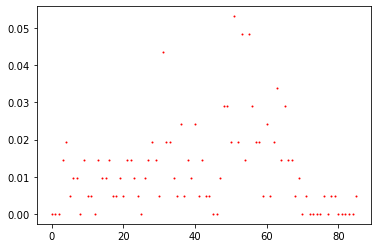

Edge Weight Hist


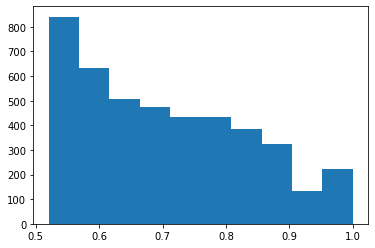

['番茄', '草', '青菜', '蓝莓', '浮萍', '橄榄', '海棠', '蕨菜', '生菜', '油菜花', '花菜', '草莓', '大头菜', '梅花', '西兰花', '油麦菜', '卷心菜', '茼蒿', '玉兰', '笋']
动物
Number of Nodes: 196
Node Degree Hist


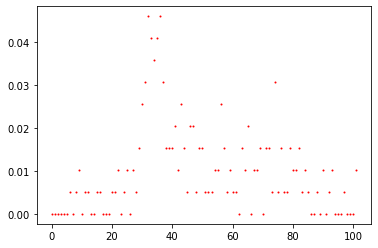

Edge Weight Hist


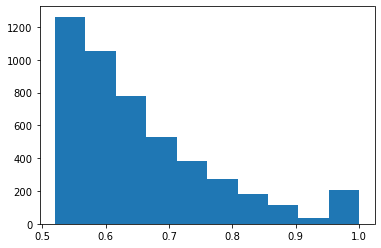

['刺猬', '海狮', '海豹', '狼', '狐狸', '猪', '鲤鱼', '犀牛', '鲸鱼', '老虎', '美洲狮', '狮子', '豚鼠', '海獭', '松鼠', '熊', '金钱豹', '豹子', '羊驼', '大灰狼']
自然物
Number of Nodes: 7
Node Degree Hist


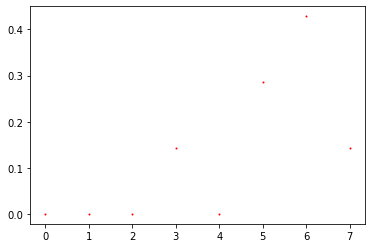

Edge Weight Hist


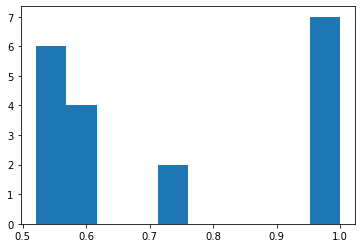

['水晶', '岩石', '宝石', '珍珠', '钻石', '大理石', '石头']
食物
Number of Nodes: 141
Node Degree Hist


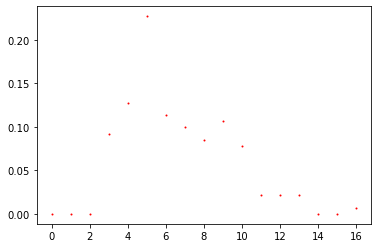

Edge Weight Hist


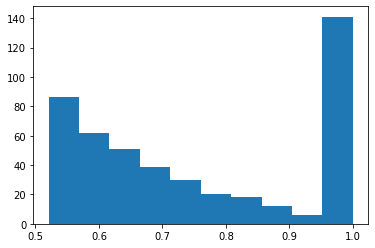

['果汁', '辣椒粉', '花生酱', '煎蛋卷', '通心粉', '油饼', '披萨', '辣椒酱', '纯净水', '谷子', '馅饼', '春卷', '橘子汽水', '牛奶', '乌龙茶', '蛋卷冰淇淋', '花生', '小麦', '牛肉面', '苏打水']
身体部位
Number of Nodes: 37
Node Degree Hist


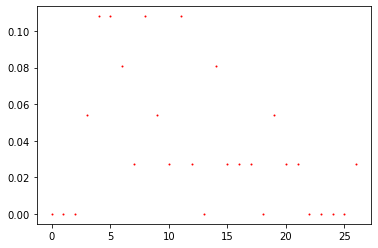

Edge Weight Hist


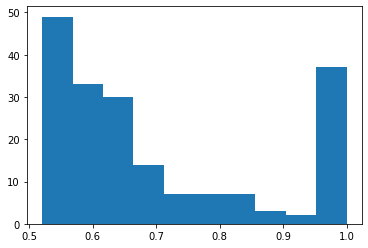

['臀部', '脚趾', '大腿', '肩膀', '拇指', '心脏', '膝盖', '手臂', '脚背', '指甲', '喉', '嘴唇', '腿', '血管', '睫毛', '眉毛', '骨架', '手指', '关节', '脚后跟']
人造物
Number of Nodes: 251
Node Degree Hist


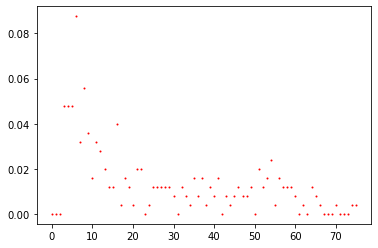

Edge Weight Hist


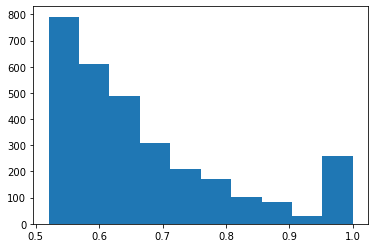

['防尘罩', '眼镜盒', '卷帘', '耳罩', '浴帘', '背心', '栏杆', '墙纸', '胶带', '火药', '枕套', '运动装', '灯罩', '画纸', '镜框', '杯垫', '透明胶带', '长袖', '蚊帐', '蜡笔']
交通工具
Number of Nodes: 42
Node Degree Hist


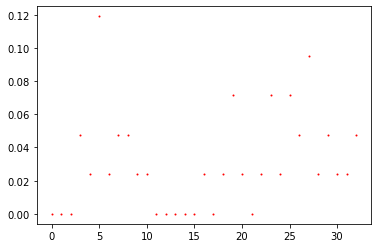

Edge Weight Hist


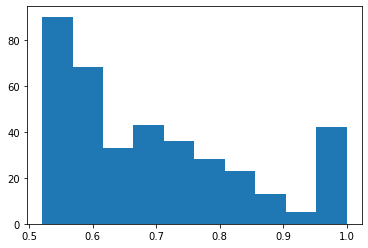

['卡车', '汽车', '吉普车', '车辆', '赛车', '电动汽车', '摩托车', '轿车', '游艇', '公交车', '跑车', '豪华轿车', '三轮车', '卡丁车', '巴士', '出租车', '自行车', '豪华客轮', '行李车', '敞篷跑车']


In [46]:
cue_words = []

maincategorys = NodeAttributeValueList(G_ConceptNetwork,'maincategory')
for i in maincategorys:
    print(i)
    view = ClusterFilter(G_ConceptNetwork,'maincategory',i,'weight',0,True,'Gephi')
    cue_words_maincategory = NodeSampling(view,20,'top')
    cue_words = cue_words + cue_words_maincategory
    print(cue_words_maincategory)

In [1135]:
filename = '02_Graph/ConceptNetwork_maincategory_食物_weight0.graphml'
Gephi2Cytoscape(filename)

02_Graph/ConceptNetwork_maincategory_食物_weight0 graphml


In [31]:
cue_words

['蕨菜',
 '青菜',
 '橄榄',
 '生菜',
 '番茄',
 '卷心菜',
 '花菜',
 '大头菜',
 '西兰花',
 '蓝莓',
 '茼蒿',
 '红薯',
 '花',
 '笋',
 '草',
 '仙人掌',
 '油麦菜',
 '莴笋',
 '草莓',
 '浮萍',
 '煎蛋卷',
 '奶酪',
 '牛奶',
 '肉丸',
 '饼干',
 '油饼',
 '蛋卷',
 '火腿肠',
 '奶油',
 '清汤',
 '火腿',
 '香肠',
 '甜点',
 '巧克力牛奶',
 '棉花糖',
 '粥',
 '馒头',
 '腊肠',
 '酸奶',
 '烤排骨',
 '刺猬',
 '鲤鱼',
 '猪',
 '海豹',
 '豚鼠',
 '狐狸',
 '鲸鱼',
 '海狮',
 '松鼠',
 '狼',
 '犀牛',
 '鲶鱼',
 '美洲狮',
 '猴子',
 '老虎',
 '羊驼',
 '网纹蟒',
 '熊',
 '鲫鱼',
 '黄鼠狼',
 '便盆',
 '漏斗',
 '清洁球',
 '针线篮',
 '桶',
 '陀螺',
 '扫帚',
 '猫砂',
 '簸箕',
 '管道',
 '储蓄罐',
 '沙漏',
 '万花筒',
 '骨灰盒',
 '积木',
 '地图',
 '滑轮',
 '排水管',
 '哑铃',
 '壁画',
 '汽车',
 '卡车',
 '吉普车',
 '赛车',
 '轿车',
 '跑车',
 '车辆',
 '豪华轿车',
 '公交车',
 '摩托车',
 '电动汽车',
 '卡丁车',
 '出租车',
 '三轮车',
 '巴士',
 '敞篷跑车',
 '房车',
 '自行车',
 '行李车',
 '手推车',
 '沟渠',
 '岩石',
 '水晶',
 '宝石',
 '月亮',
 '沙坑',
 '煤田',
 '大理石',
 '钻石',
 '雪花',
 '煤炭',
 '流星',
 '白银',
 '珍珠',
 '冰雹',
 '星星',
 '露珠',
 '沙尘暴',
 '石头',
 '雪球',
 '臀部',
 '肩膀',
 '脚趾',
 '脚背',
 '嘴唇',
 '拇指',
 '膝盖',
 '大腿',
 '心脏',
 '腿',
 '关节',
 '手臂',
 '脚后跟',
 '血管',
 '手指',
 '脚',
 '牙齿',
 '喉',
 '手掌',

In [1129]:
df_ = pd.DataFrame(cue_words, columns=['cue_word'])
df_ = Sample_PWA(df_,0.5,'picture_naming')
df_.to_csv('02_Graph/Wenyue/PictureNamingResult.csv',index=False)

In [196]:
# # 利用Degree选出重要的节点
# selected_nodes = [n for n,v in G_ConceptNetwork.nodes(data=True) if G_ConceptNetwork.degree(n) > 1200]  
# G_ = G_ConceptNetwork.subgraph(selected_nodes)

# # 利用边的权重筛选出核心子图中最紧密的连接，构成子图
# selected_edges = [(u,v,e) for u,v,e in G_.edges(data=True) if e['weight'] > 8]
# G_Center = nx.Graph(selected_edges)

# # 选出子图中最大的Connected Component，作为试验用的子图
# # nx.number_connected_components(G_Center)
# largest_cc = max(nx.connected_components(G_Center), key=len)
# len(largest_cc)
# G_Exp = G_Center.subgraph(largest_cc)

### 计算图指标

In [224]:
# 计算 loseness centrality
closeness_centrality = nx.closeness_centrality(G_Exp)

# 重映射值域
# closeness_centrality.update((x, translate(y,min(closeness_centrality.values()), max(closeness_centrality.values()), 0, 20 )) for x, y in closeness_centrality.items())

# 写入节点属性
nx.set_node_attributes(G_Exp, closeness_centrality, "closeness_centrality")

G_Exp.nodes["豆腐"]

{'closeness_centrality': 0.21428571428571427,
 'subcategory': '固态干粮',
 'maincategory': '食物'}

### 可视化

In [ ]:
# 利用pyvis进行可视化（需在浏览器中打开）
# nt = net.Network(notebook=True)
# nt.from_nx(T)
# nt.show('nx.html')


# 导出gephi格式
# nx.write_gexf(T, "CCFD_Core.gexf")

## 试验用的概念-特征网络

In [247]:
df_exp = df_complete[df_complete['Concept'].isin(largest_cc)]
df_exp.head()

,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage
45,安全帽,可以,可以-保护,29.0,8.33,9.0,人造物,工具,0.717619
46,安全帽,可以,可以-保护头,20.0,8.33,9.0,人造物,工具,0.717619
47,安全帽,是,是-帽子,17.0,8.33,9.0,人造物,工具,0.717619
48,安全帽,有,有-带子,16.0,8.33,9.0,人造物,工具,0.717619
49,安全帽,是,是-硬的,14.0,8.33,9.0,人造物,工具,0.717619


In [268]:
# 计算特征线索度
cue_validities = []

for row in df_exp.iterrows():
    cue_validity = row[1]['Frequency'] / sum(list(df_complete[df_complete['Feature']==row[1]['Feature']]['Frequency']))
    cue_validities.append(cue_validity)

df_exp['cue_validity'] = cue_validities
df_exp.head()

<ipython-input-268-82335c6fc863>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['cue_validity'] = cue_validities


,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity
45,安全帽,可以,可以-保护,29.0,8.33,9.0,人造物,工具,0.717619,0.041011
46,安全帽,可以,可以-保护头,20.0,8.33,9.0,人造物,工具,0.717619,0.361276
47,安全帽,是,是-帽子,17.0,8.33,9.0,人造物,工具,0.717619,0.129977
48,安全帽,有,有-带子,16.0,8.33,9.0,人造物,工具,0.717619,0.137468
49,安全帽,是,是-硬的,14.0,8.33,9.0,人造物,工具,0.717619,0.019729


In [ ]:
# 保存文件
# df_exp.to_csv("03_Experiment/Concept-Feature-Network_Experiment.csv", index=False)
# df_exp = pd.read_csv("03_Experiment/Concept-Feature-Network_Experiment.csv")

## 生成命名测试用数据 Picture Naming Test Data Generation

In [44]:
## Input 
# word_list = ['豆浆', '菠萝汁', '咖啡']
word_list = cue_words

data = {
    'currentStep': 0,
    'steps': []
}

for word in word_list:
    new_step = {
        'name':word,
        # 'image':'local-resource:///Users/zhanghexin/aphasia_viz/src/assets/test_images/'+word+'.jpeg',
        'image':'/test_images/'+word+'.jpeg',
        'countdown':20,
        'result':'fail',
        'status':'unchecked',
    }
    data['steps'].append(new_step)

with open("test_picture-naming.json", "w") as f: 
    json.dump(data, f, ensure_ascii=False)

## 生成语义特征分析训练用数据 SFA Data Generation

In [45]:
## Input 
# word_list = ['豆浆', '菠萝汁', '咖啡']
word_list = cue_words


data = {
    'currentStep': 0,
    'steps': [],
}

for word in word_list:
    new_step = {
        'name': word,
        # 'image':'local-resource:///Users/zhanghexin/aphasia_viz/src/assets/test_images/'+word+'.jpeg',
        'image':'/test_images/'+word+'.jpeg',

        'countdown':20,
        'result':'fail',
        'status':'unchecked',
        'response':'',
        'tab': [],
    }

    concept = word
    rel_list = list(df_complete['Rel'].unique())
    
    for rel in rel_list:
        feature_type = rel+'-'
        data_tab = {
            'feature_type':feature_type,
            'dataSource':[]
        }
        
        feature_list = list(df_complete[(df_complete['Concept']==concept)&(df_complete['Rel']==rel)].sort_values(by=['cue_validity'],ascending=False)['Feature'].unique())[0:10]
        for feature in feature_list:
            cue_validity = "%.3f" % float(df_complete[(df_complete['Concept']==concept)&(df_complete['Feature']==feature)]['cue_validity'])
            related_concepts = List_Related_Concepts(concept,feature)[0:5]
            confused_feature = List_Confused_Feature(concept,feature)[0:5]
            data_row = {
                # 'key':feature_list.index(feature),
                'key':concept+'/'+feature,
                'name':feature,
                'cue_validity':cue_validity,
                'related_concepts': ', '.join(related_concepts),
                'confused_feature': ', '.join(confused_feature).replace(feature_type,''),
                'status': 'NO',
            }
            data_tab['dataSource'].append(data_row)
        new_step['tab'].append(data_tab)

    data['steps'].append(new_step)

with open("test_SFA.json", "w") as f: 
    json.dump(data, f, ensure_ascii=False)

In [154]:
rel_list

['可以', '是', '其他', '需要', '像', '有']

In [ ]:
{
    key: "1",
    name: "有-四个车轮",
    cue_validity: 1.0,
    related_concepts: "",
    status: "NO",
},

In [144]:
concept = '豆浆'

data_concepts = {
    'tab':[]
}

for rel in rel_list:
    feature_type = rel+'-'
    data_tab = {
        'feature_type':feature_type,
        'dataSource':[]
    }
    
    feature_list = list(df_complete[(df_complete['Concept']==concept)&(df_complete['Rel']==rel)].sort_values(by=['cue_validity'],ascending=False)['Feature'].unique())[0:10]
    for feature in feature_list:
        cue_validity = "%.3f" % float(df_complete[(df_complete['Concept']==concept)&(df_complete['Feature']==feature)]['cue_validity'])
        related_concepts = List_Related_Concepts(concept,feature)[0:5]
        confused_feature = List_Confused_Feature(concept,feature)[0:5]
        data = {
            'key':feature_list.index(feature),
            'name':feature,
            'cue_validity':cue_validity,
            'related_concepts': ', '.join(related_concepts),
            'confused_feature': ', '.join(confused_feature).replace(feature_type,''),
            'status': 'NO',
        }
        data_tab['dataSource'].append(data)

    data_concepts['tab'].append(data_tab)

In [145]:
data_concepts

{'tab': [{'feature_type': '可以-',
   'dataSource': [{'key': 0,
     'name': '可以-解渴',
     'cue_validity': '0.022',
     'related_concepts': '白水, 白粥, 百事可乐, 冰棍, 冰红茶',
     'confused_feature': '饱腹, 调味, 送礼, 冲泡, 食用',
     'status': 'NO'},
    {'key': 1,
     'name': '可以-饮用',
     'cue_validity': '0.017',
     'related_concepts': '八宝粥, 白饭, 白酒, 白水, 白糖',
     'confused_feature': '饱腹, 炒, 调味, 送礼, 冲泡',
     'status': 'NO'},
    {'key': 2,
     'name': '可以-买卖',
     'cue_validity': '0.001',
     'related_concepts': '白砂糖, 百事可乐, 棒棒糖, 包子, 爆米花',
     'confused_feature': '饱腹, 炒, 调味, 送礼, 冲泡',
     'status': 'NO'}]},
  {'feature_type': '是-',
   'dataSource': [{'key': 0,
     'name': '是-早上的',
     'cue_validity': '0.166',
     'related_concepts': '八宝粥, 白粥, 春卷, 豆腐脑, 馄饨',
     'confused_feature': '好吃的, 黄色的, 零食, 咸的, 面食',
     'status': 'NO'},
    {'key': 1,
     'name': '是-早餐',
     'cue_validity': '0.118',
     'related_concepts': '八宝粥, 白粥, 包子, 春卷, 蛋糕',
     'confused_feature': '好吃的, 黄色的, 零食, 咸的, 面食',
     '

In [105]:
list(df_complete[(df_complete['Concept']=='豆浆')&(df_complete['Rel']=='是')].sort_values(by=['cue_validity'],ascending=False)['Feature'].unique())[0:10]

['是-早上的',
 '是-早餐',
 '是-豆制品',
 '是-乳白色的',
 '是-液体',
 '是-饮料',
 '是-粘稠的',
 '是-白色的',
 '是-甜的',
 '是-香的']

In [139]:
concept = '豆浆'
feature = '是-早上的'

# cue_validity
cue_validity = "%.2f" % float(df_complete[(df_complete['Concept']==concept)&(df_complete['Feature']==feature)]['cue_validity'])
print(cue_validity)

#related_concepts
related_concepts = List_Related_Concepts(concept,feature)[0:5]
print(', '.join(related_concepts))

#confused_features
confused_feature = List_Confused_Feature(concept,feature)[0:5]
print(', '.join(confused_feature).replace('是-',''))

0.17
八宝粥, 白粥, 春卷, 豆腐脑, 馄饨
好吃的, 黄色的, 零食, 咸的, 面食


## 模拟患者语义网络

In [283]:
## stimuli

# 手动填写 stimuli

# intial_stimuli = [
#     ['耳朵','手掌', '脚后跟','肩膀','牙齿','鼻子'],
#     ['鸽子','麻雀', '燕子','天鹅','喜鹊','猫头鹰'],
#     ['猴子','狮子', '兔子','老虎','老鼠','奶牛'],
#     ['苹果','香蕉', '葡萄','甘蔗','柑橘','西瓜'],
#     ['萝卜','土豆', '白菜','黄瓜','韭菜','茄子'],
#     ['直升机','火车', '帆船','卡车','轿车','摩托车'],
#     ['茅草屋','人行天桥', '车库','立交桥','高速公路','喷泉'],
#     ['衬衫','毛衣', '夹克','袜子','围巾','裤子'],
#     ['沙发','椅子', '餐桌','书柜','马桶','冰箱'],
#     ['扫帚','雨伞', '剪刀','纱布','拐杖','筷子']
# ]

#检验 stimuli 是否在数据库中
#len(df_rel[df_rel['head']=="脚跟"])

# for cue in cues:
#     if len(df_complete[df_complete['Concept']==cue]) == 0:
#         print(cue)
#     else:
#         print(df_complete[df_complete['Concept']==cue])



# 随机采样生成 stimuli
subcategories = list(df_exp.下级类别.unique())

intial_stimuli = []
for subcategory in subcategories:
    stimuli = list(df_exp[df_exp['下级类别']==subcategory].sort_values(by=['familiarity', 'coverage','concretness'],ascending=False).head(120)["Concept"].unique())
    intial_stimuli.append(stimuli)
    print(stimuli,subcategory)
intial_stimuli = sum(intial_stimuli,[])

['钢笔', '黑板擦', '擀面杖', '缝衣针'] 工具
['衬衫', '夹克', '风衣'] 服饰
['瓜', '番茄', '黄瓜'] 蔬菜
['豆浆', '菠萝汁', '豆奶', '咖啡'] 酒水饮料
['柑橘', '荔枝', '金橘'] 水果
['鸡蛋', '大饼', '米线', '麻花'] 固态干粮
['宝石'] 自然物
['茶壶', '炖锅', '筷子'] 餐具
['弹簧床垫', '毛毯', '床垫', '窗帘'] 家具
['豆豉', '辣椒酱', '醋', '草莓酱'] 调料
['莲花', '菊花', '雏菊', '玫瑰'] 花草
['轿车', '房车', '豪华轿车'] 车
['鲸鱼', '螺蛳', '金鱼'] 水生动物
['刀', '飞镖', '棍棒'] 武器
['电冰箱'] 电器
['鸽子', '鹅', '金丝雀'] 鸟
['飞机', '飞碟', '飞艇'] 飞机
['飞盘'] 玩具
['蟒蛇', '狗'] 陆生动物
['豪华客轮'] 船
['桦木', '黄金树'] 树木
['火腿', '腊肠', '腊肉'] 肉食
['胶囊'] 医疗用品
['毛毛虫', '昆虫'] 昆虫
['篮球'] 运动器材


In [589]:
## 选择提示词相关的所有语义特征，作为个人语义网络数据
df_complete_initial = df_exp[df_exp['Concept'].isin(intial_stimuli)]

# 复制一份，默认所有概念-特征对的激活状态为 0
df_compare_initial = df_complete_initial.copy()
df_compare_initial['activation'] = 0

# 【模拟】患者的语义特征分析数据
df_pwa_initial = Sample_PWA(df_complete_initial, 0.5, 'activation')

# 将与患者数据对应的概念-语义特征对的激活状态设为 1
for row in df_pwa_initial.iterrows():
    row_index = df_compare_initial.loc[(df_compare_initial['Concept'] == row[1]['Concept']) & (df_compare_initial['Feature'] == row[1]['Feature'])].index
    df_compare_initial['activation'][row_index]=1

df_compare_initial.head()
# df_compare_initial.to_csv('04_Compare/Concept-Feature-Network_compare_initial.csv', index=False)


<ipython-input-589-855e1395782a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compare_initial['activation'][row_index]=1


,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity,activation
1724,宝石,是,是-石头,11.0,8.33,9.0,自然物,自然物,0.721707,0.081093,0
1725,宝石,是,是-贵的,10.0,8.33,9.0,自然物,自然物,0.721707,0.035495,1
1726,宝石,是,是-矿物,10.0,8.33,9.0,自然物,自然物,0.721707,0.178721,0
1727,宝石,有,有-多种颜色,9.0,8.33,9.0,自然物,自然物,0.721707,0.003912,0
1728,宝石,是,是-亮的,8.0,8.33,9.0,自然物,自然物,0.721707,0.056352,1


In [1169]:
List_Semantic_Feature(df_compare_initial,'轿车')

,Feature,cue_validity,activation
21667,有-四个车轮,1.000000,1
21659,需要-牌照,1.000000,0
21663,有-车牌,0.333333,1
21646,有-油门,0.333333,0
21666,有-轱辘,0.333333,0
21664,有-挡风玻璃,0.333086,0
21642,像-面包车,0.230769,0
21645,有-引擎,0.189409,0
21656,像-跑车,0.155000,1
21657,像-自行车,0.129630,1


In [604]:
Extract_Associate_SemanticFeature(df_compare_initial, 'Concept', 'Feature', '轿车', '房车')

{'像-面包车',
 '其他-交通',
 '可以-乘坐',
 '可以-买卖',
 '可以-行驶',
 '是-工具',
 '是-车',
 '有-发动机',
 '有-座位',
 '有-方向盘',
 '有-窗户',
 '有-车厢',
 '有-轮子',
 '有-门',
 '需要-保养',
 '需要-加油',
 '需要-司机',
 '需要-检查',
 '需要-汽油',
 '需要-油',
 '需要-清洗',
 '需要-电',
 '需要-维护',
 '需要-驾驶'}

In [471]:
# 从患者数据中提取连接强度
df_pwa_ConceptNetwork = Extract_Association_Network(df_pwa_initial, 'Concept', 'Feature', 0)

# 加入到测试网络数据中
for u, v, e in G_Exp.edges(data=True):
    row = df_pwa_ConceptNetwork[(df_pwa_ConceptNetwork['Source']==u)&(df_pwa_ConceptNetwork['Target']==v)]
    if(len(df_pwa_ConceptNetwork[(df_pwa_ConceptNetwork['Source']==u)&(df_pwa_ConceptNetwork['Target']==v)]!=None)!=0):
        e['initial_weight'] = int(row['Strength'])
    else:
        e['initial_weight'] = 0

In [476]:
df_pwa_initial.head()

,Concept,Rel,Feature,Frequency,familiarity,concretness,上级类别,下级类别,coverage,cue_validity,activation
1725,宝石,是,是-贵的,10.0,8.33,9.0,自然物,自然物,0.721707,0.035495,1
1728,宝石,是,是-亮的,8.0,8.33,9.0,自然物,自然物,0.721707,0.056352,1
1729,宝石,是,是-硬的,8.0,8.33,9.0,自然物,自然物,0.721707,0.011274,1
1730,宝石,是,是-闪亮的,7.0,8.33,9.0,自然物,自然物,0.721707,0.777778,1
1732,宝石,像,像-石头,7.0,8.33,9.0,自然物,自然物,0.721707,0.024284,1


TypeError: cannot convert the series to <class 'int'>

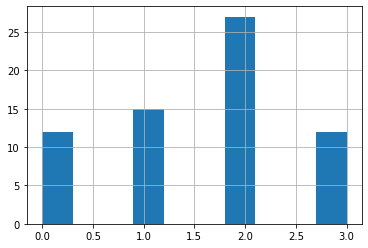

In [509]:
# 由cue_validity的和决定节点的命名情况
# 0,1,2,3 分别代表三次测试中成功命名的次数

def Picture_Naming(x):
    if(x>4.5):
        return 3
    elif(x>2):
        return 2
    elif(x>1.5):
        return 1
    else:
        return 0

df_pwa_initial_PictureNaming = df_pwa_initial.groupby('Concept').sum().sort_values(by='cue_validity',ascending=False)
df_pwa_initial_PictureNaming['picture_naming'] = df_pwa_initial_PictureNaming['cue_validity'].apply(lambda x: picture_naming(x))
df_pwa_initial_PictureNaming['picture_naming'].hist()


In [510]:
int(df_pwa_initial_PictureNaming[df_pwa_initial_PictureNaming.index=='飞镖']['picture_naming'])

3

In [592]:
# 给 G_Exp 加入模拟的图片命名数据

for node in G_Exp.nodes:
    picture_naming_result = df_pwa_initial_PictureNaming[df_pwa_initial_PictureNaming.index==node]['picture_naming']
    if(len(picture_naming_result)==1):
        G_Exp.nodes[node]['semantic_feature'] = 1
        G_Exp.nodes[node]['picture_naming'] = int(picture_naming_result)
    else:
        G_Exp.nodes[node]['semantic_feature'] = 0
        G_Exp.nodes[node]['picture_naming'] = random.randint(0,3)

# G_Exp.nodes['胶水']

In [584]:
# 查询某个节点属性的所有可能情况
# query a graph for all the possible attributes that might have been applied across the various nodes
# set(np.array([G_Exp.nodes[n].keys() for n in G_Exp.nodes]).flatten())
# set(np.array([G_Exp.nodes[n]['maincategory'] for n in G_Exp.nodes]).flatten())

{'交通工具', '人造物', '动物', '植物', '自然物', '食物'}

In [593]:
## 可视化

# 保存为d3可用的json文件
with open('04_Compare/ConceptNetwork_Experiment.json','w+') as f:
    f.write(json.dumps(nx.node_link_data(G_Exp), ensure_ascii=False))


# 导出gephi格式
# nx.write_gexf(G_Exp, "04_Compare/ConceptNetwork_Experiment.gexf")

In [596]:
## subgraph query
selection = ['糕点', '可可巧克力', '醋', '豆浆', '豆奶', '可口可乐', '比萨', '筷子', '鸡肉', '棉花糖']
G_selection = G_Exp.subgraph(selection)

In [602]:
with open('04_Compare/ConceptNetwork_Experiment_Selection.json','w+') as f:
    f.write(json.dumps(nx.node_link_data(G_selection), ensure_ascii=False))

## 从患者网络中抽取关联网络

In [174]:
df_impair_individual_concept_network = Extract_Association_Network(df_impair_individual, 'Concept', 'Feature', 5)
df_impair_individual_concept_network.head()

,Source,Target,Strength
0,安全带,手机,6
1,白糖,橙汁,9
2,白糖,大饼,6
3,白糖,豆豉,9
4,白糖,豆浆,8


In [176]:
df_impair_individual_feature_network = Extract_Association_Network(df_impair_individual, 'Feature', 'Concept', 5)
df_impair_individual_feature_network.head()

In [ ]:
df_impair_individual_feature_network.to_csv('01_Processed Data/SemanticFeature_Link_PWA-Minor.csv')

## Node_Link CSV to Json (NodeTrix / G6)

In [ ]:
# Nodetrix json format

# "nodes":[
#     {"name":"Myriel","group":1},
#         ...]
# "links":[
#     {"source":1,"target":0,"value":1},
#         ...]

In [ ]:
df_node = pd.read_csv('00_Raw Data/CCFD_concept_info.csv')
df_node.head()

,Id,Label,concept,familiarity,concretness,上级类别,superior category,下级类别,subcategory,coverage
0,安全带,安全带,Safety belt,9.00,9.0,人造物,artificial object,工具,tool,0.851345
1,安全帽,安全帽,Safety hat,8.33,9.0,人造物,artificial object,工具,tool,0.717619
2,安慰奶嘴,安慰奶嘴,pacifier,9.00,9.0,人造物,artificial object,餐具,tableware,0.663182
3,鹌鹑,鹌鹑,quail,7.00,9.0,动物,animal,鸟,bird,0.731581
4,鹌鹑蛋,鹌鹑蛋,Quail egg,9.00,9.0,食物,food,固态干粮,solid food,0.741644


In [ ]:
df_concept_network = pd.read_csv('02_Graph/Concept_Link.csv')
df_concept_network.head()

,Source,Target,Strength
0,安全带,安全帽,7
1,安全带,按键,5
2,安全带,按摩器,2
3,安全带,按钮,6
4,安全带,八哥,1


In [ ]:
data = Node_Link_CSV2Json(df_impair_individual_concept_network,df_node,"Label","下级类别", "edges", "name")
%%time

nodes: 276
links: 5201


UsageError: Line magic function `%%time` not found.


In [ ]:
data = Node_Link_CSV2Json(test_2,df_node,"Feature","Rel", "edges", "name")
%%time

nodes: 82
links: 577


In [ ]:
with open("04_G6/CCFD_G6_Concept_PWA-Minor.json_276", "w") as f: 
    json.dump(data, f, ensure_ascii=False)

In [ ]:
def read_json_file(filename, typeName):
    with open(filename) as f:
        G = nx.Graph()
        data = json.load(f)
        links = data['edges']
        edges = []
        for i in links:
            edge = []
            edge.append(data['nodes'][links[i['id']]['source']]['label'])
            edge.append(data['nodes'][links[i['id']]['target']]['label'])
            edges.append(tuple(edge))
        G.add_edges_from(edges)
        for i in G.nodes:
            G.nodes[i]['type']=typeName
            G.nodes[i]['activation_status']=0
    return G